In [1]:
import json
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
import math
import seaborn as sns
sns.set()
sns.set_style("darkgrid")

In [2]:
def moving_average(input_list, gamma=0):
    output_list = list()
    ma = input_list[0]
    for element in input_list:
        ma = gamma * ma + (1-gamma) * element
        output_list.append(ma)
    return output_list

In [3]:
def plot_eval(evals):
    for i, key in enumerate(evals.keys()):
        figure(num=None, figsize=(14, 10*len(evals)), dpi=80, facecolor='w', edgecolor='k')
        ax = plt.subplot(len(evals), 1, i+1)
        sorted_keys = sorted(list(evals[key]["eval"].keys()))
        sorted_values = [evals[key]["eval"][sorted_key] for sorted_key in sorted_keys]
        plt.bar(sorted_keys, sorted_values)
        plt.title(key+evals[key]["trained"]+" split: "+str(evals[key]["online_train_test_split"]))
        plt.ylim(0, 1)
        plt.show()

In [4]:
def plot_stuff(phonebook, file_names, title, val=False):
    linestyles = ['-', '--', '-.', ':']
    colours = ['tab:blue', 'tab:orange','tab:green','tab:red','tab:purple',
               'tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
    group_by_index = dict()
    for dir_name, dir_index in phonebook.items():
        if dir_index in group_by_index:
            group_by_index[dir_index].append(dir_name)
        else:
            group_by_index[dir_index] = [dir_name]
    
    for i, dir_index in enumerate(group_by_index.keys()):
        figure(num=None, figsize=(14, 10*len(group_by_index)), dpi=80, facecolor='w', edgecolor='k')
        ax = plt.subplot(len(group_by_index), 1, i+1)
        
        for k, dir_name in enumerate(sorted(group_by_index[dir_index])):
            colour = colours[k]
            print(dir_name)
            try:
                record = json.load(open(os.path.join(dir_name, "record.json"), "r"))
                config = json.load(open(os.path.join(dir_name, "env_config.json"), "r"))
                for j, file_name in enumerate(file_names):
                    style = linestyles[j]
                    training_loss = record[file_name]
                    batch_size = config["batch_size"]
                    display_file_name = file_name.split("_")[0]

                    hyper_params = "bow" if config["bag_of_words"] else config["obs_mode"][:3]
                    if config["online"]:
                        hyper_params += \
                            ", online split: {}, epd {}, lr {}, {}".format(
                                config["online_train_test_split"], config["epochs_per_online_dataset"],
                                config["lr"], "Forward" if "forward" in dir_name else "Backward"
                            )
                    print(dir_index, hyper_params, record["progress"])
                    if val=="val":
                        for key, loss in training_loss.items():
                            hor_axis = np.array(range(len(loss)))
                            quantity_to_plot = moving_average(loss)
                            plt.plot(hor_axis, quantity_to_plot, label=hyper_params+"(diff: {})".format(key))
                            ax.annotate(round(quantity_to_plot[-1], 2), 
                                        xy=(hor_axis[-1], quantity_to_plot[-1]),
                                       linestyle=style,
                                       color=colour)
                    elif val=="succ":
                        if isinstance(training_loss, list):
                            hor_axis = np.array(range(len(training_loss))) * config["epoch_per_case_record"]
                            quantity_to_plot = moving_average(training_loss)
                            plt.plot(hor_axis, quantity_to_plot, label=hyper_params+" "+display_file_name,
                                       linestyle=style,
                                       color=colour)
                            ax.annotate(round(quantity_to_plot[-1], 2), 
                                        xy=(hor_axis[-1], quantity_to_plot[-1]))
                        else:
                            for key, loss in training_loss.items():
                                hor_axis = np.array(range(len(loss))) * config["epoch_per_case_record"]
                                quantity_to_plot = moving_average(loss)
                                plt.plot(hor_axis, quantity_to_plot, label=hyper_params+"(diff: {})".format(key),
                                       linestyle=style,
                                       color=colour)
                                ax.annotate(round(quantity_to_plot[-1], 2), 
                                            xy=(hor_axis[-1], quantity_to_plot[-1]))
                                print(key, round(quantity_to_plot[-1], 2))
                    else:
                        quantity_to_plot = moving_average(np.array(training_loss))
                        hor_axis = np.array(range(len(training_loss)))
                        plt.plot(hor_axis, quantity_to_plot, label=hyper_params,
                                       linestyle=style,
                                       color=colour)
                        ax.annotate(round(quantity_to_plot[-1], 2), 
                                    xy=(hor_axis[-1], quantity_to_plot[-1]))
            except Exception as e:
                print(dir_name)
                print("Exception: {}".format(e))
                pass
        plt.legend()
        plt.xlabel("Epochs trained")
        ax.set_title("{}: {}".format(title, dir_index))
        plt.show()

In [5]:
directory = "/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic"
dir_phonebook = dict()
dir_evals = dict()
for dir_name in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, dir_name)) and (not dir_name.startswith('.')):
        if "2019_11_17" < dir_name:
            config = json.load(open(os.path.join(directory, dir_name, "env_config.json"), "r"))
            config_index = config['train_dirs']
            if isinstance(config_index, list):
                train_index = ", ".join([single_index.split("/")[-1] for single_index in config_index])
                test_index = ", ".join([single_index.split("/")[-1] for single_index in config["test_dirs"]])
            online = config["online"]
            if online:
                dir_phonebook[os.path.join(directory, dir_name)] = \
                    "Trained on {} and tested on: {}".format(config["train_dirs"], config["test_dirs"])
            else:
                dir_phonebook[os.path.join(directory, dir_name)] = \
                    "Trained on: {}; Tested on: {}".format(train_index, test_index)
            
            dir_evals[dir_name] = {
                "trained": "k={}, l={}".format(config["axioms"], config["length"]),
                "online_train_test_split": config["online_train_test_split"],
                "eval": {}
            }
            for eval_name in os.listdir(os.path.join(directory, dir_name)):
                if eval_name.startswith("k"):
                    sr = json.load(open(os.path.join(directory, dir_name, eval_name), "r"))
                    dir_evals[dir_name]["eval"][eval_name.split(".")[0]] = sr
                    
configs = dict()
for dir_name in dir_phonebook:
    config = json.load(open(os.path.join(dir_name, "env_config.json"), "r"))
    if "gnn_type" in config and "hidden_layers" in config:
        configs[dir_name.split("/")[2]] = {
            "learning rate": config["lr"],
            "epoch": config["epoch"],
            "state dimension": config["state_dim"],
            "batch size": config["batch_size"],
            "problem index": "{}-{}".format(config["train_val_diffs"][0], config["train_val_diffs"][-1]),
            "gnn_type": config["gnn_type"],
            "lr_decay": config["lr_decay"],
            "hidden_layers": config["hidden_layers"],
            "train_val_diffs": config["train_val_diffs"],
            "test_diffs": config["test_diffs"]
        }
config_df = pd.DataFrame(configs)
config_df.sort_index(axis=1, inplace=True)

In [6]:
from copy import deepcopy
forward_book = deepcopy(dir_phonebook)

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_771082
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.128%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_901063
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.11399999999999999%


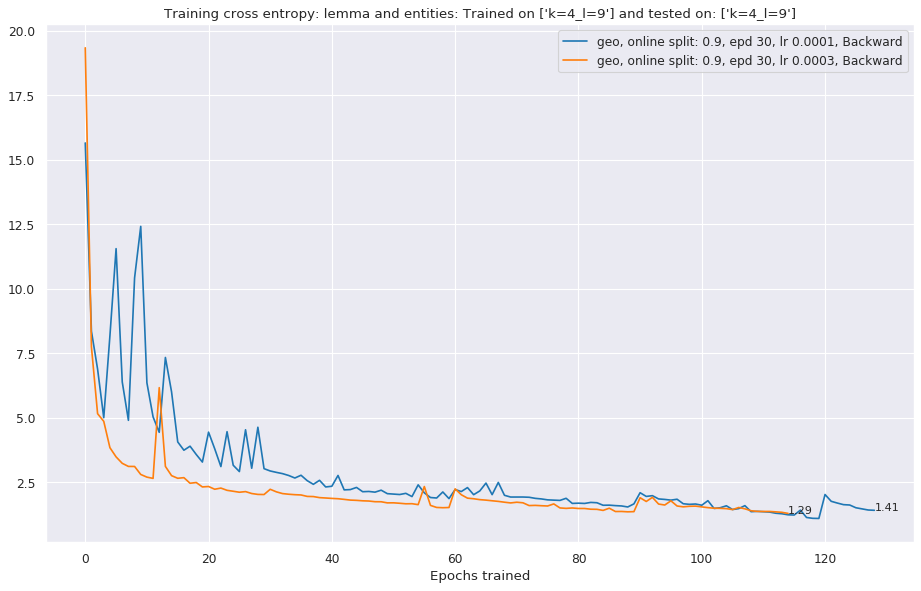

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_744052
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.22300000000000003%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_847392
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.2%


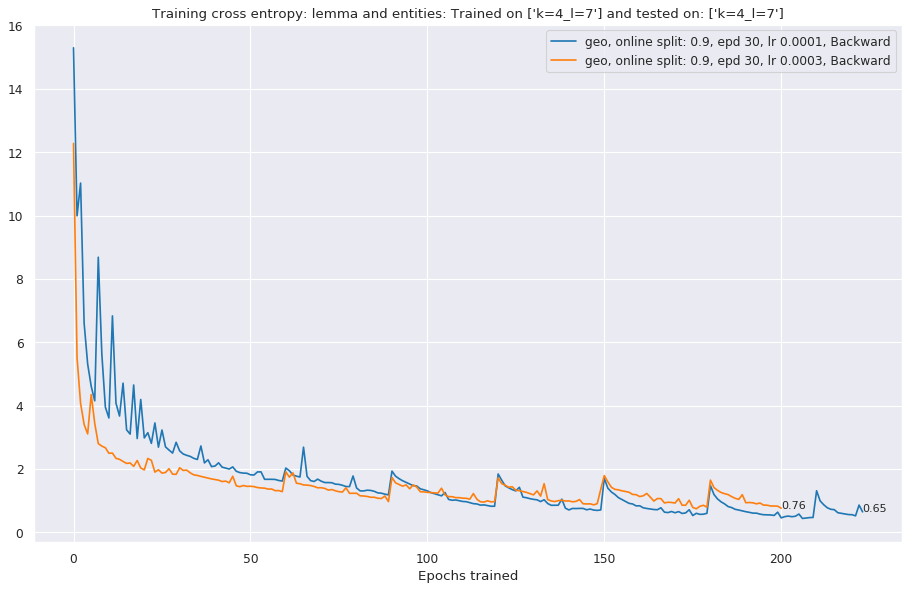

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_665684
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.27699999999999997%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_698475
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.233%


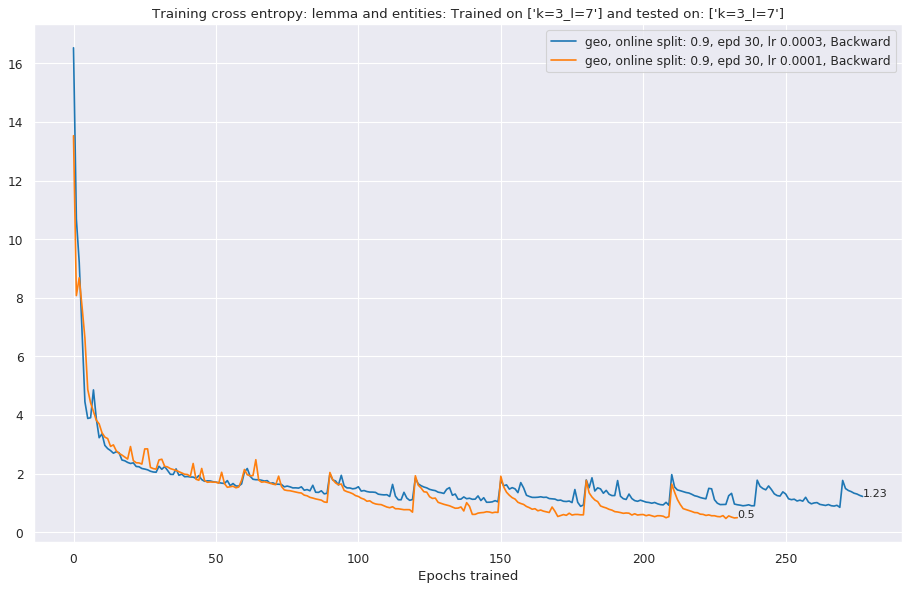

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_618745
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 1.2%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_766425
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 1.189%


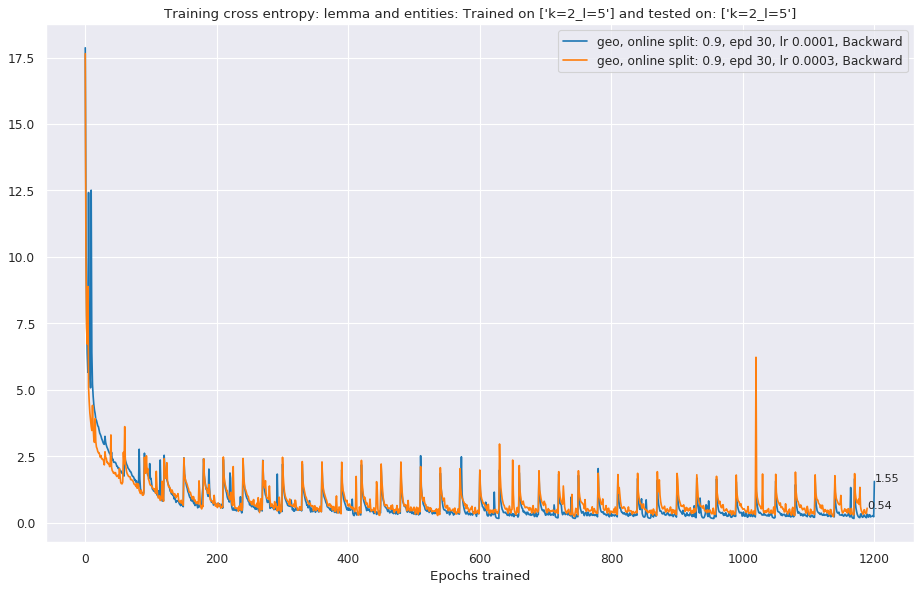

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_605467
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.5479999999999999%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_759221
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.5459999999999999%


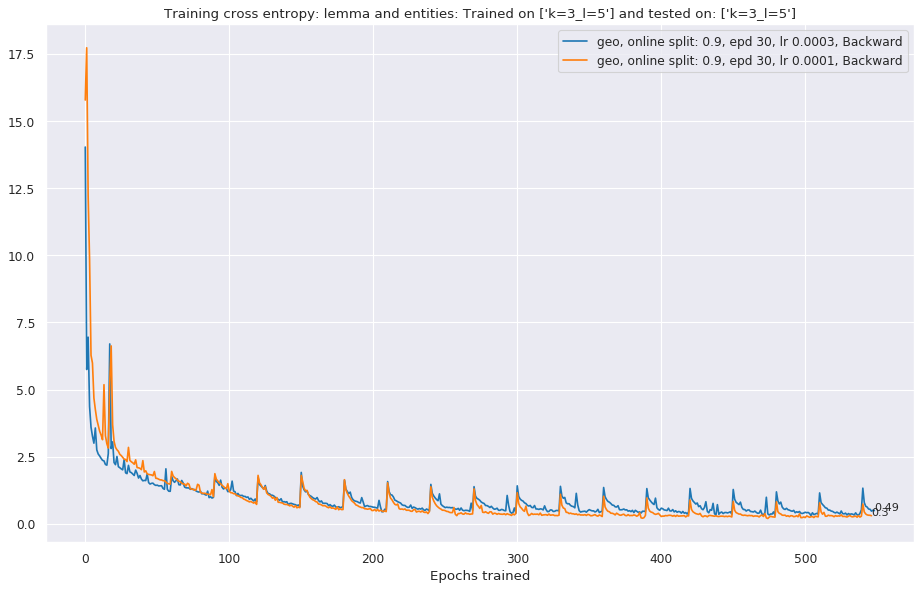

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_775242
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 2.669%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_795069
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 2.7289999999999996%


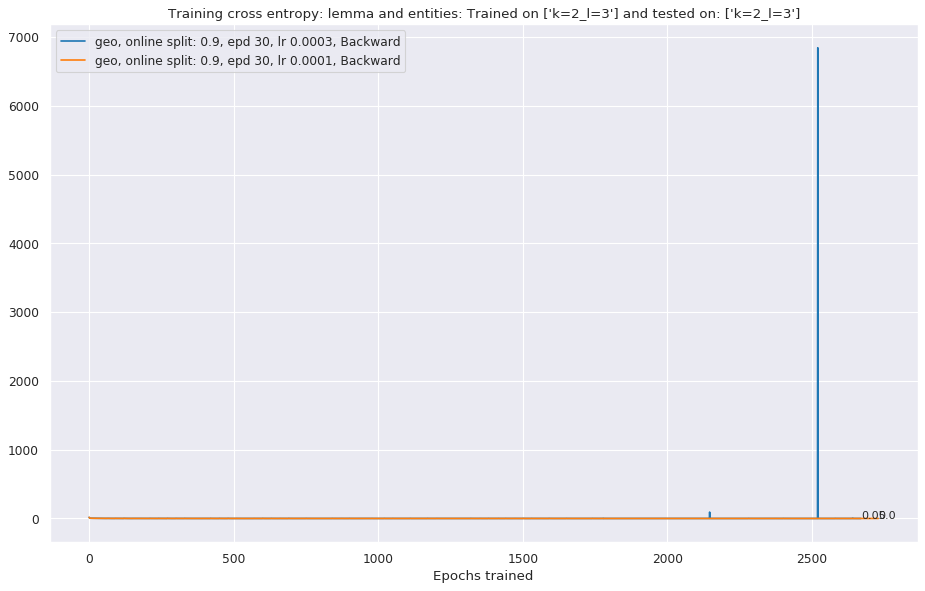

In [7]:
plot_stuff(dir_phonebook, ["train_losses"], "Training cross entropy: lemma and entities")

In [ ]:
plot_stuff(dir_phonebook, ["train_lemma_accs"], "Training lemma accuracies")

In [ ]:
plot_stuff(dir_phonebook, ["test_lemma_accs"], "Test lemma accuracies")

In [ ]:
plot_stuff(dir_phonebook, ["train_ent_accs"], "Training entity accuracies")

In [ ]:
plot_stuff(dir_phonebook, ["test_ent_accs"], "Test entity accuracies")

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_771082
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.128%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_901063
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.11399999999999999%


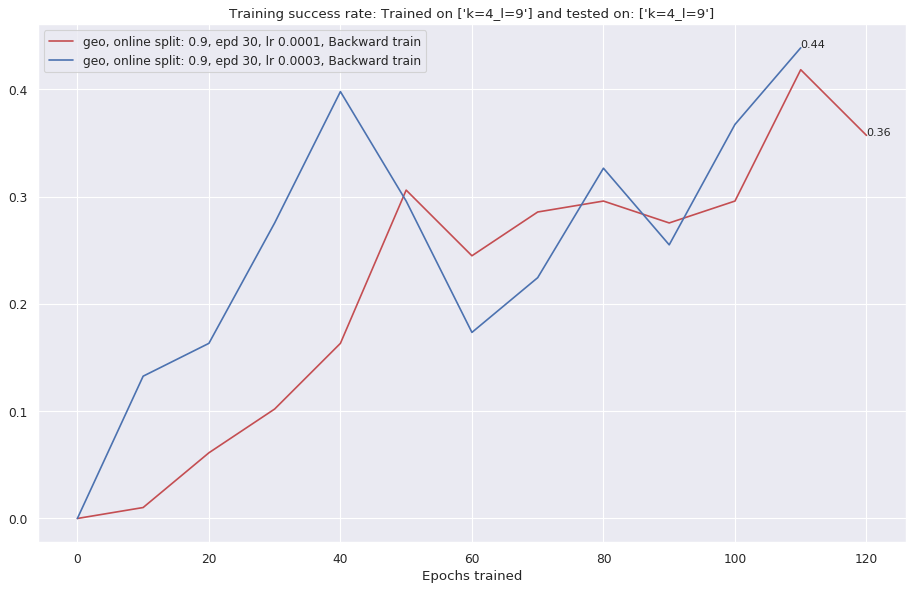

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_744052
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.22300000000000003%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_847392
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.2%


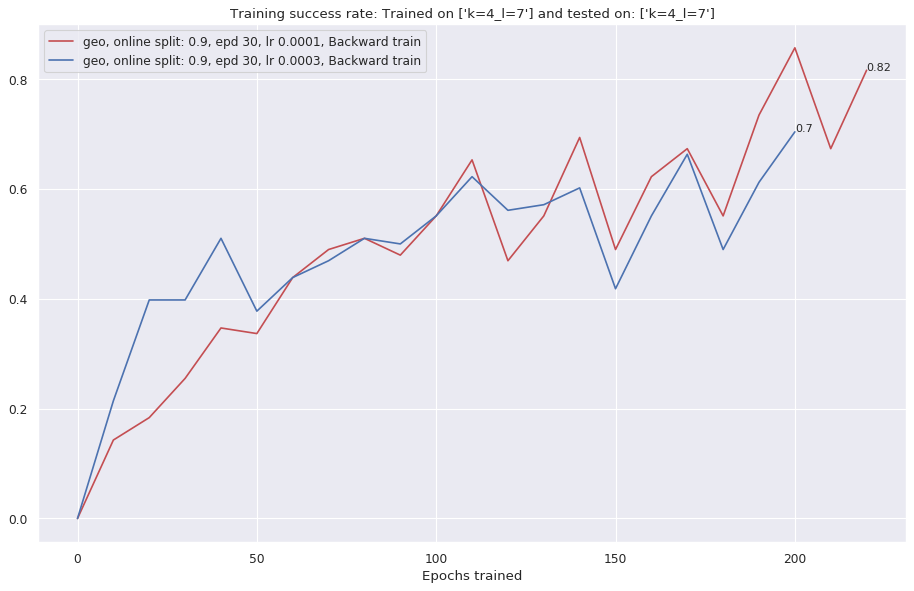

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_665684
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.27699999999999997%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_698475
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.233%


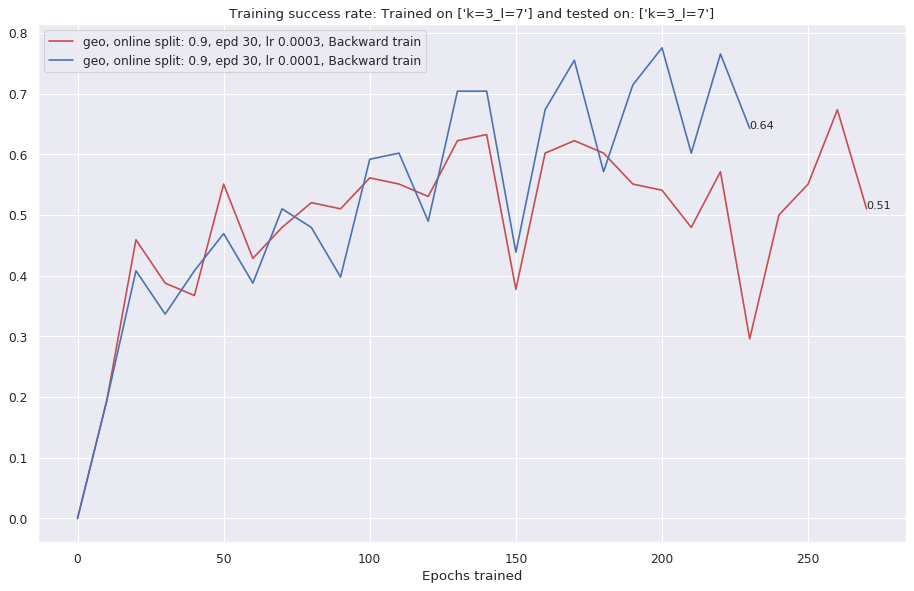

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_618745
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 1.2%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_766425
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 1.189%


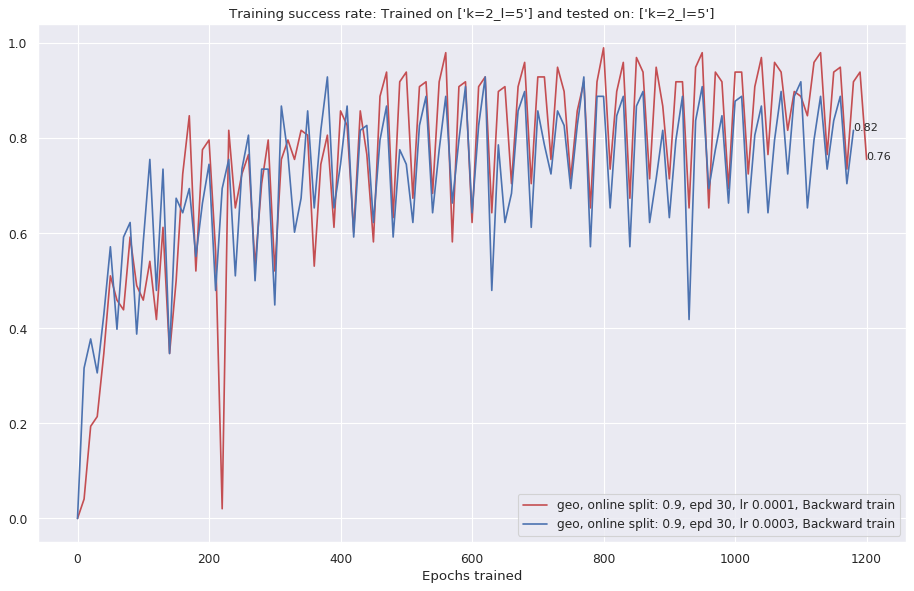

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_605467
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.5479999999999999%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_759221
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.5459999999999999%


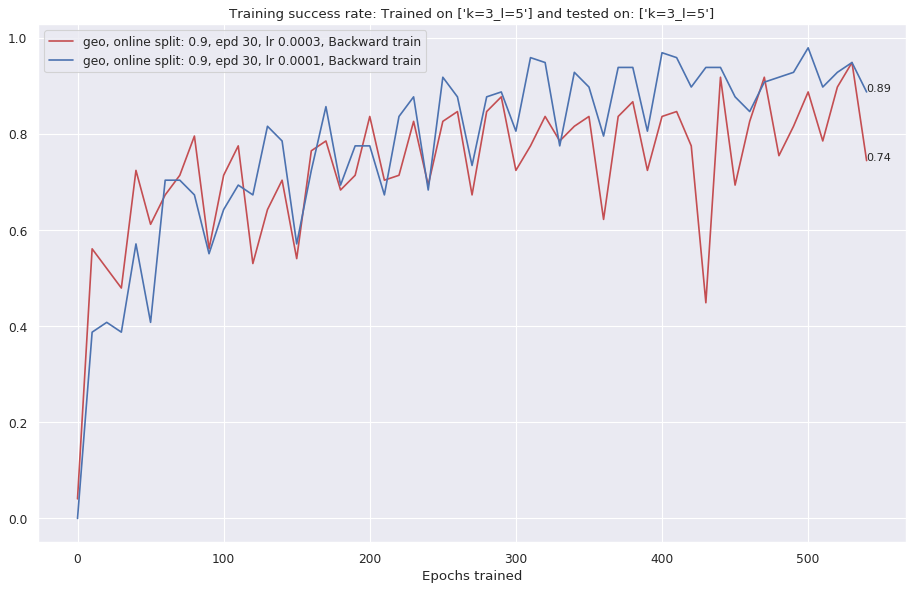

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_775242
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 2.669%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_795069
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 2.7289999999999996%


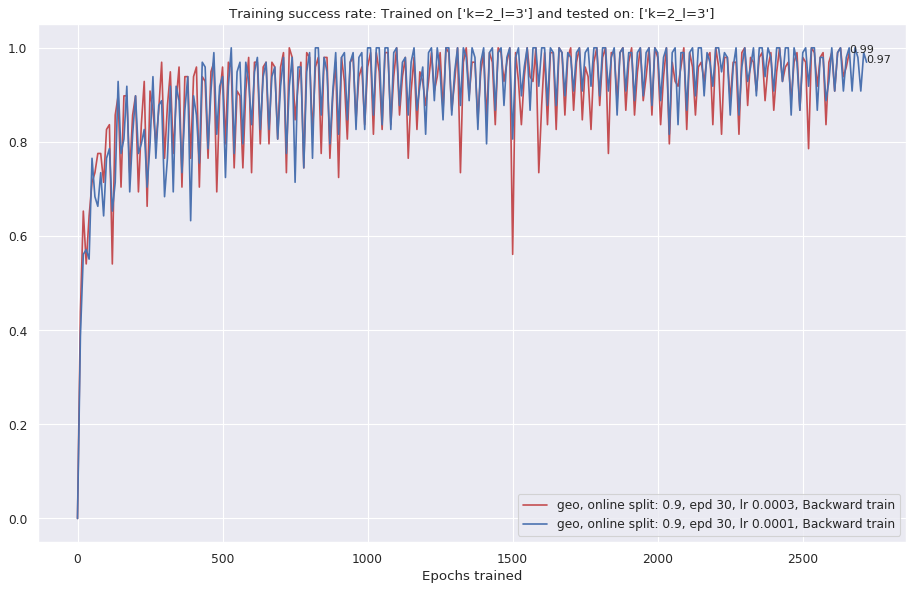

In [6]:
plot_stuff(dir_phonebook, ["train_first_success_rates"], 
           "Training success rate", val="succ")

In [ ]:
plot_stuff(dir_phonebook, ["test_first_success_rates"], 
           "Success rate", val="succ")

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_771082
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.128%
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.128%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_901063
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.11399999999999999%
Trained on ['k=4_l=9'] and tested on: ['k=4_l=9'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.11399999999999999%


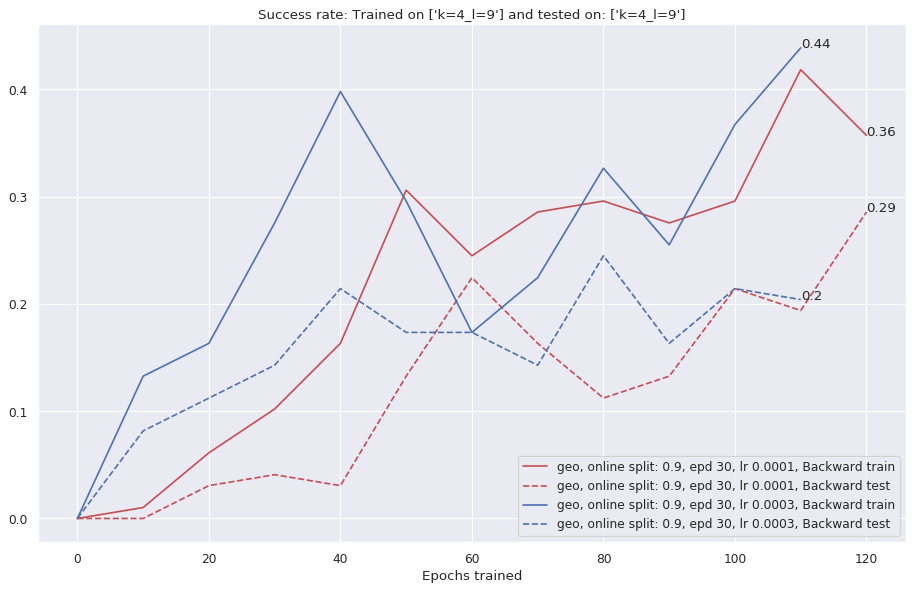

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_744052
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.22300000000000003%
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.22300000000000003%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_847392
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.2%
Trained on ['k=4_l=7'] and tested on: ['k=4_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.2%


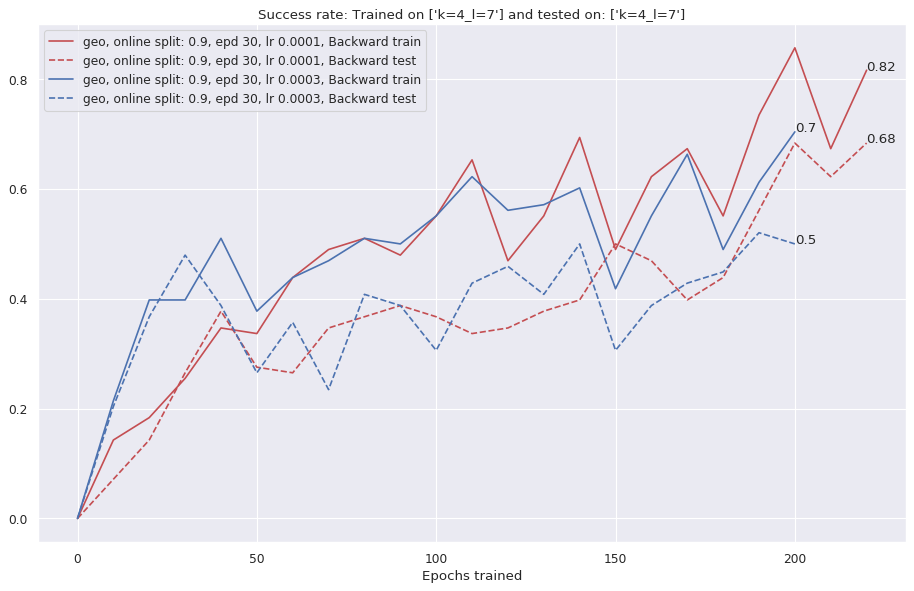

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_665684
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.27699999999999997%
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.27699999999999997%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_698475
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.233%
Trained on ['k=3_l=7'] and tested on: ['k=3_l=7'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.233%


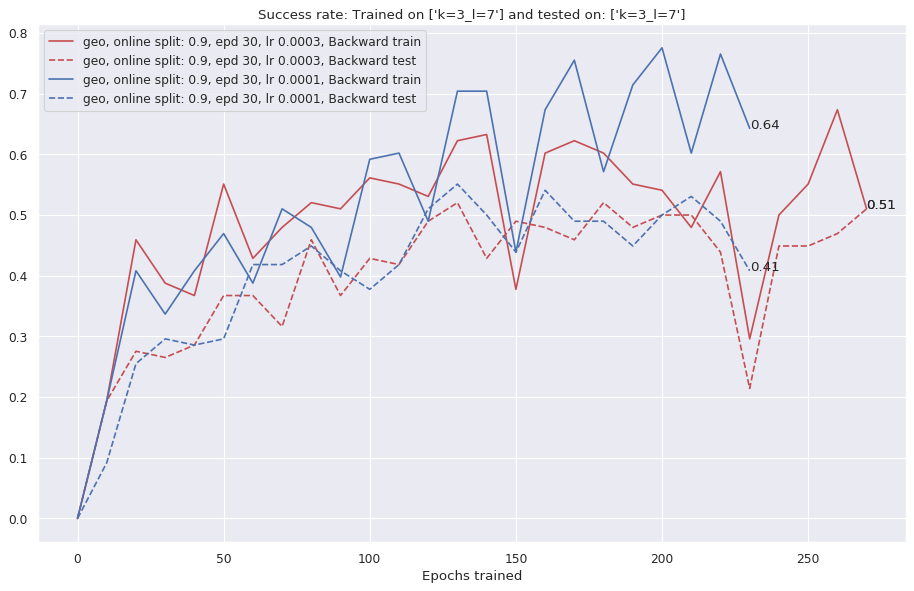

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_618745
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 1.2%
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 1.2%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_766425
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 1.189%
Trained on ['k=2_l=5'] and tested on: ['k=2_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 1.189%


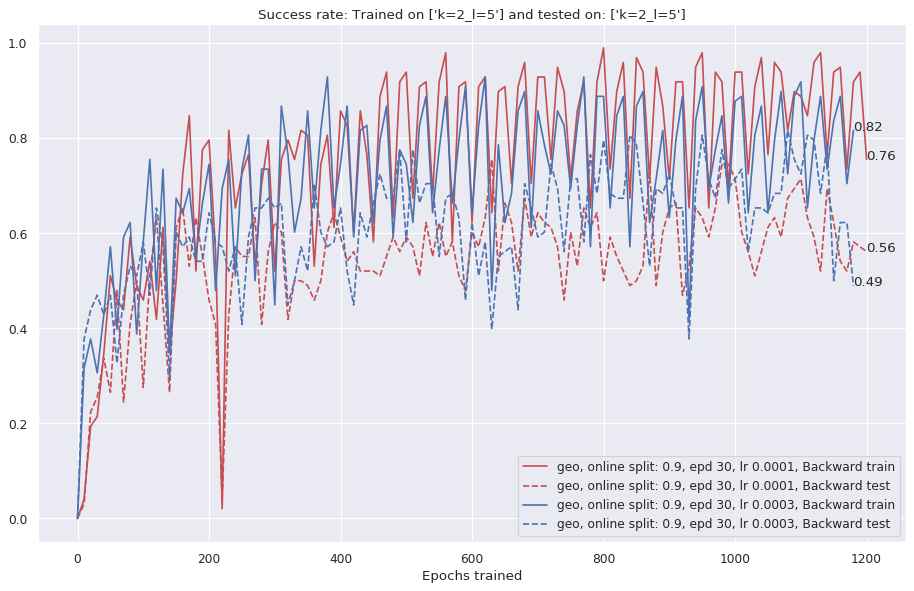

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_605467
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.5479999999999999%
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 0.5479999999999999%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_759221
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.5459999999999999%
Trained on ['k=3_l=5'] and tested on: ['k=3_l=5'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 0.5459999999999999%


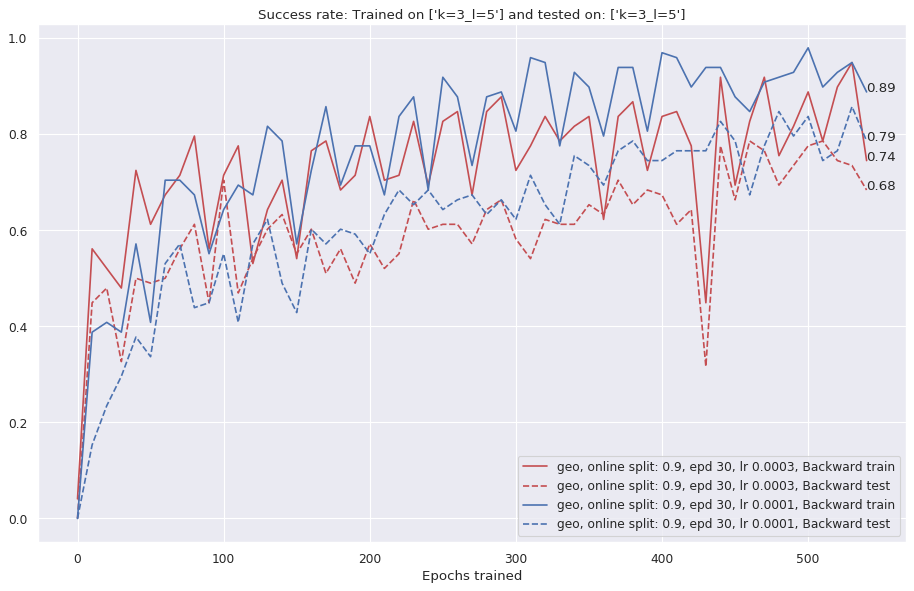

/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_775242
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 2.669%
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0003, Backward 2.669%
/scratch/hdd001/home/ywu/ineqResultsEasy/sl_back_basic/2019_11_27_03_50_30_795069
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 2.7289999999999996%
Trained on ['k=2_l=3'] and tested on: ['k=2_l=3'] geo, online split: 0.9, epd 30, lr 0.0001, Backward 2.7289999999999996%


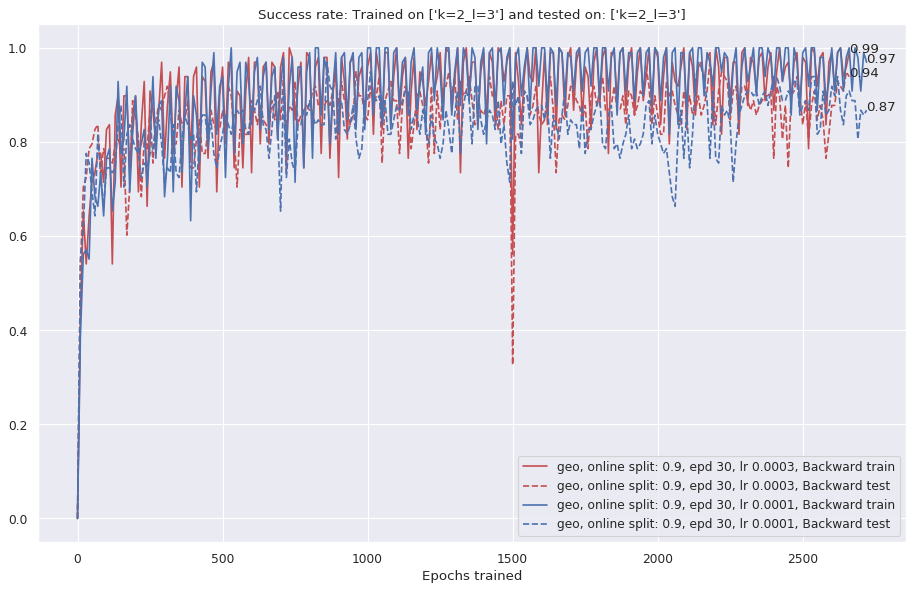

In [12]:
plot_stuff(dir_phonebook, ["train_first_success_rates", "test_first_success_rates"], 
           "Success rate", val="succ")